In [1]:
import os, sys, glob, re
import datetime
import numpy as np
from calendar import monthrange
import h5py

sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument/')
from concat_raw import get_num_days_pings, get_data_from_h5
from echogram_decomp import find_nearest_time_idx

import matplotlib.pyplot as plt
from modest_image import imshow
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set default colormap
plt.rcParams['image.cmap'] = 'jet'

/Users/wujung/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/wujung/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [45]:
%matplotlib inline

In [4]:
pname = '/Volumes/wjlee_apl_2/ooi_zplsc_600m/'
yr = 2017
mn = 8
dd = 21
h5_fname = '/Volumes/wjlee_apl_2/ooi_zplsc_all_h5/CE04OSPS_20170%02d%02d.h5' % (mn,dd)

In [29]:
all_hr = range(24)  # list of all hour: 0-23
all_minutes = range(0,60)  # list of all minutes: 1-10
every_ping = [datetime.datetime(yr,mn,dd,hr,minutes,0) \
                  for hr in all_hr for minutes in all_minutes]
pings_per_day = len(all_hr)*len(all_minutes)
pings_per_hr = len(all_minutes)

In [31]:
pings_per_day

1440

In [48]:
# Open h5 file
f = h5py.File(h5_fname,'r')

In [49]:
# Get f['data_times'] idx for every hour in all days in the month
all_idx = [find_nearest_time_idx(f['data_times'],pp) for pp in every_ping]
all_idx = np.array(all_idx)  # to allow numpy operation   

In [50]:
# Extract timing and Sv data
notnanidx = np.int_(all_idx[~np.isnan(all_idx)])
data_times = np.empty(all_idx.shape)  # initialize empty array
data_times[~np.isnan(all_idx)] = f['data_times'][notnanidx.tolist()]
    
Sv_tmp = f['Sv'][:,:,0]
Sv_mtx = np.empty((Sv_tmp.shape[0],Sv_tmp.shape[1],all_idx.shape[0]))
Sv_mtx[:] = np.nan
Sv_mtx[:,:,~np.isnan(all_idx)] = f['Sv'][:,:,notnanidx.tolist()]

bin_size = f['bin_size'][0]      # size of each depth bin 

In [51]:
f.close()

In [52]:
Sv_mtx.shape

(3, 1072, 1440)

In [53]:
# Set xtick and labels
ping_idx = range(0,24*pings_per_hr,pings_per_hr)
ping_labels = [str(x) for x in range(24)]

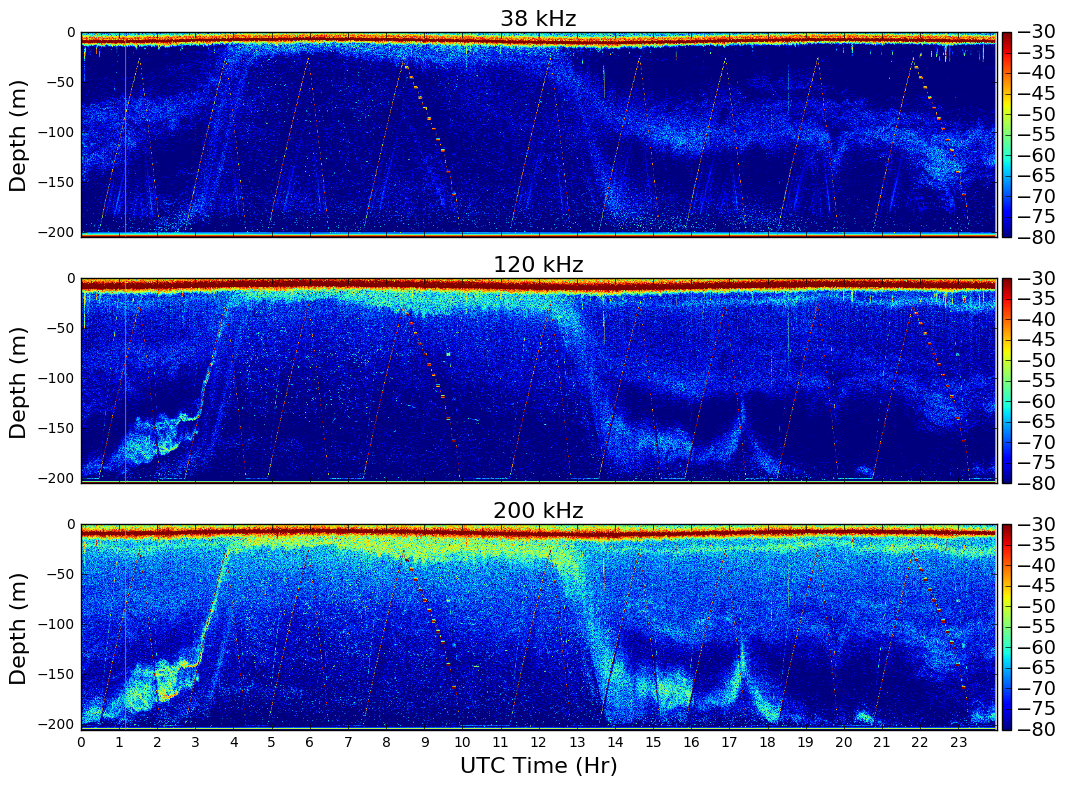

In [55]:
fig,ax = plt.subplots(3,sharex=True,sharey=True)
for ff in range(3):
    im = ax[ff].imshow(Sv_mtx[ff,:,:],aspect='auto',\
                    extent=[0,Sv_mtx.shape[2],-Sv_mtx.shape[1]*bin_size,0],\
                    vmax=-30,vmin=-80)
    ax[ff].set_xticks(ping_idx)
    ax[ff].set_xticklabels(ping_labels)
    ax[ff].set_ylabel('Depth (m)',fontsize=16)
    if ff==0:
        ax[ff].set_title('38 kHz',fontsize=16)
    elif ff==1:
        ax[ff].set_title('120 kHz',fontsize=16)
    elif ff==2:
        ax[ff].set_title('200 kHz',fontsize=16)
    divider = make_axes_locatable(ax[ff])
    cax = divider.append_axes("right", size="1%", pad=0.05)
    cbar = plt.colorbar(im,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    ax[2].set_xlabel('UTC Time (Hr)',fontsize=16)
fig.set_figwidth(12)
fig.set_figheight(9)
#plt.savefig(os.path.join(save_path,save_fname),dpi=300)
#plt.close(fig)